# Project - AllLife Credit Card Segmentation

### Background: 
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

### Objective: 
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

### Key Questions:
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and
service these customers?

### Dataset
Credit Card Customer Data.xlsx

### Attributes:
- Customer key - Identifier for the customer
- Average Credit Limit - Average credit limit across all the credit cards Total credit cards - Total number of credit cards
- Total visits bank - Total number of bank visits
- Total visits online - total number of online visits
- Total calls made - Total number of calls made by the customer

## Import Necessary Libraries & Format Notebook

In [171]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score

import scipy.cluster.hierarchy as shc

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.stats import zscore

In [126]:
# Adjust display and formatting settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [15, 8]
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500)

## Exploratory Data Analysis

### Initial Dataset Observations

In [127]:
# Read the Excel file into pandas dataframe
df = pd.read_excel("Credit Card Customer Data.xlsx")

In [128]:
# Visualize data
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [129]:
# Shape of out dataset
df.shape

(660, 7)

In [130]:
# Display data types and determine if any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [131]:
# Display statistical metrics of our data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.00,330.50,190.67,1.00,165.75,330.50,495.25,660.00
Customer Key,660.00,"55,141.44","25,627.77","11,265.00","33,825.25","53,874.50","77,202.50","99,843.00"
Avg_Credit_Limit,660.00,"34,574.24","37,625.49","3,000.00","10,000.00","18,000.00","48,000.00","200,000.00"
Total_Credit_Cards,660.00,4.71,2.17,1.00,3.00,5.00,6.00,10.00
Total_visits_bank,660.00,2.40,1.63,0.00,1.00,2.00,4.00,5.00
Total_visits_online,660.00,2.61,2.94,0.00,1.00,2.00,4.00,15.00
Total_calls_made,660.00,3.58,2.87,0.00,1.00,3.00,5.00,10.00


In [132]:
# Check for missing value in any other column
df.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [133]:
# Check for duplicate data
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


#### Observations:
- Our raw dataset has 660 rows with 7 features
- All features are int64 data types
- There are no missing values
- There are no duplicate rows
- "Sl_No" and "Customer Key" features can probably be dropped from our dataset for clustering purposes

### Data Analysis

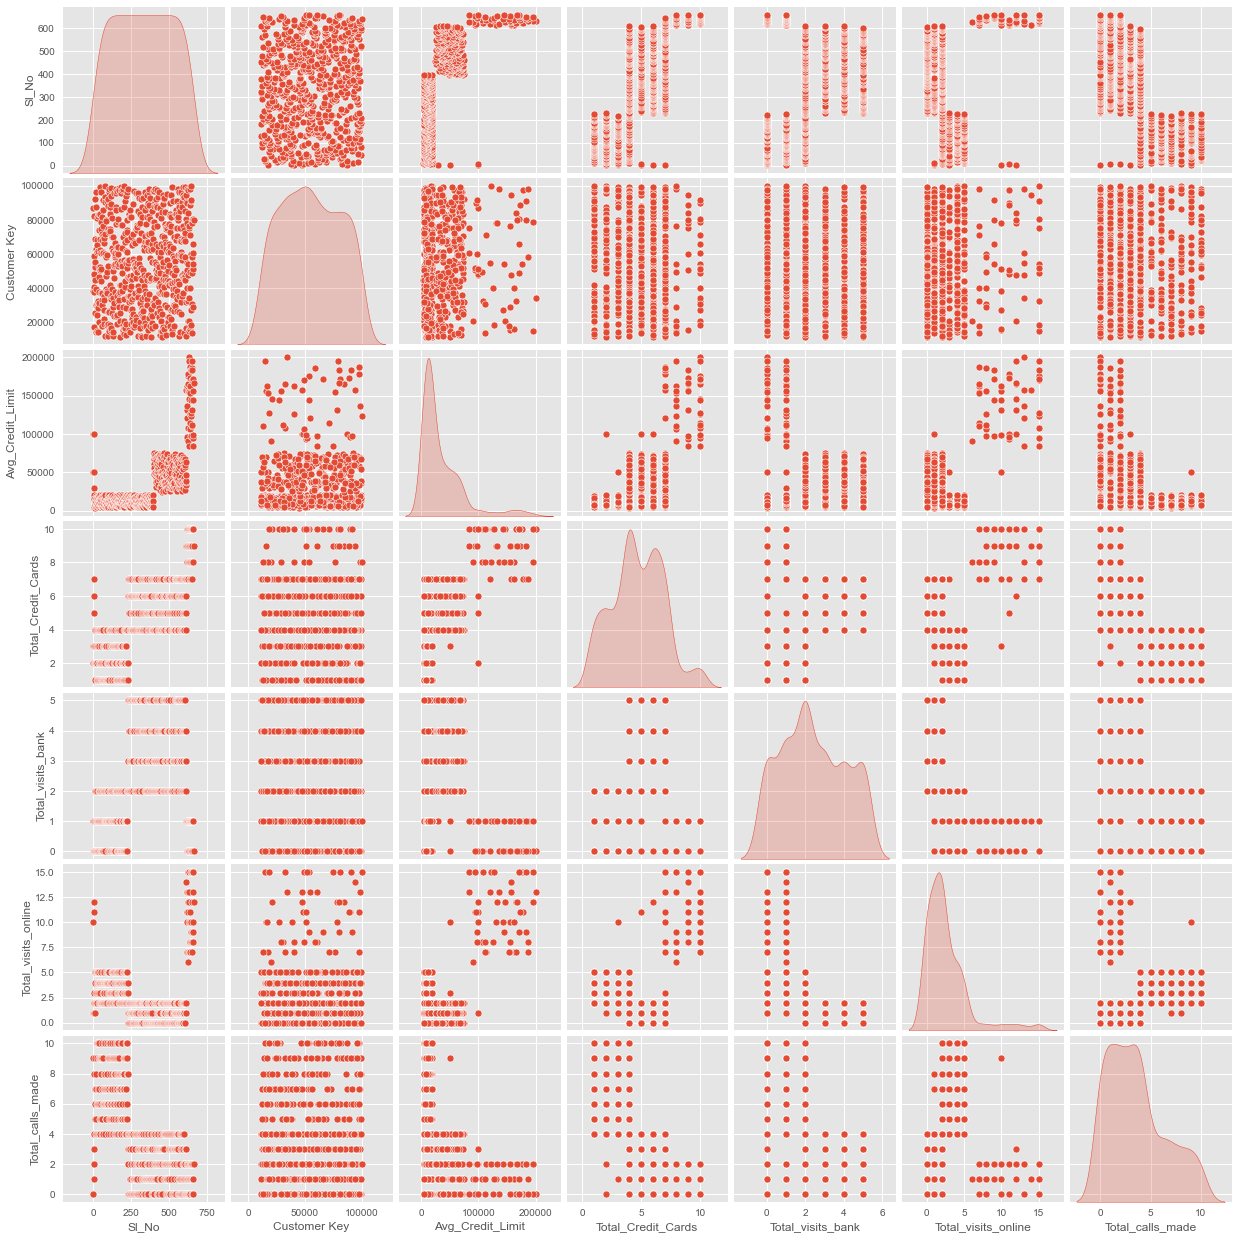

In [134]:
# Visualize features with pairplots
sns.pairplot(df,diag_kind='kde')

In [135]:
# Check for feature correlations
df.corr(method='pearson')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,1.00,0.05,0.68,0.74,0.41,0.03,-0.68
Customer Key,0.05,1.00,0.07,-0.01,-0.00,0.02,0.01
Avg_Credit_Limit,0.68,0.07,1.00,0.61,-0.10,0.55,-0.41
Total_Credit_Cards,0.74,-0.01,0.61,1.00,0.32,0.17,-0.65
Total_visits_bank,0.41,-0.00,-0.10,0.32,1.00,-0.55,-0.51
Total_visits_online,0.03,0.02,0.55,0.17,-0.55,1.00,0.13
Total_calls_made,-0.68,0.01,-0.41,-0.65,-0.51,0.13,1.00


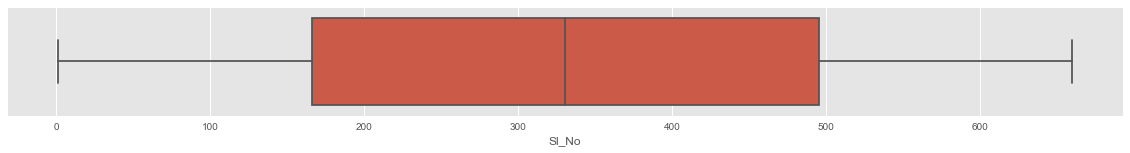

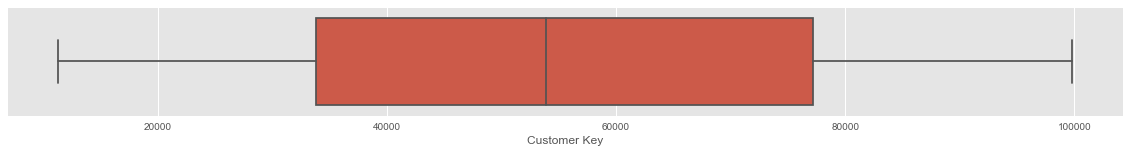

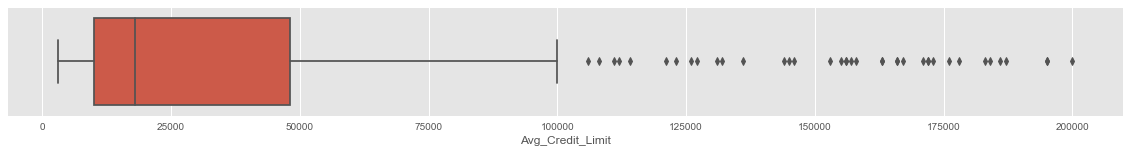

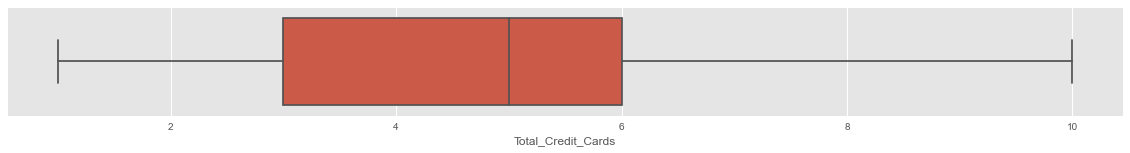

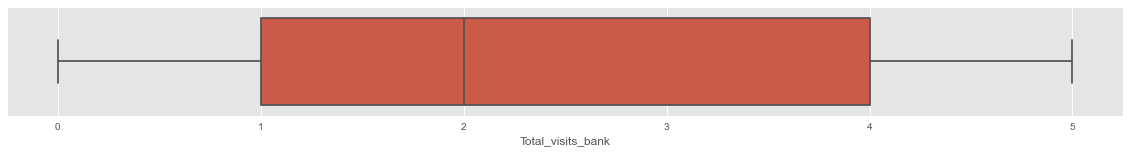

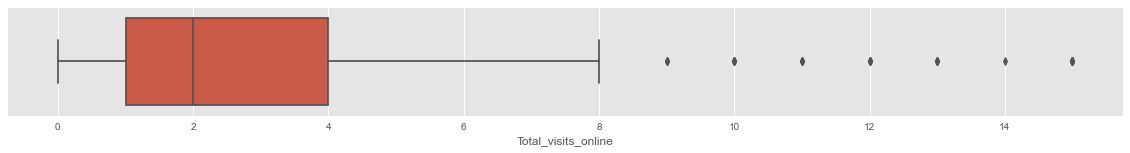

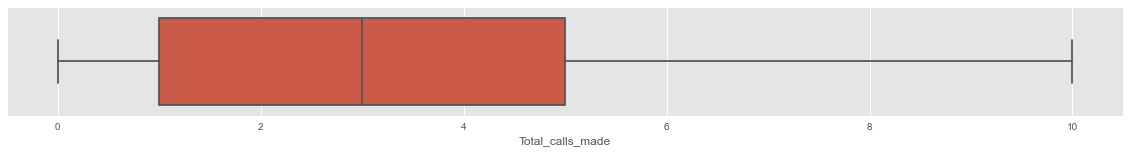

In [136]:
# visualize numerical data distributions with boxplots
for i, col in enumerate(df.columns):
    plt.figure(i, figsize=(20,2))
    sns.boxplot(x=df[col])
    plt.show()

#### Observations:

We will ignore "Sl_no" and "Customer Key" features as these will be removed for our clustering analysis

Pairplots:
- Average Credit Limit - Skewed; Appears to have 1 strong cluster and 2 weak clusters
- Total_Credit_Cards - Appears to have 4 clusters
- Total_visits_bank - Appears to have 5 to 6 clusters
- Total_visits_online - Skewed; Appears to have 1 strong cluster and 1 weak cluster above a value of 6 
- Total_calls_made - Appears to have 1 strong cluster and 1 weaker cluster

Correlations ( > +/-0.33 ):
- Avg_Credit_Limit - (+) Total_Credit_Cards, (+) Total_visits_online, (-) Total_calls_made
- Total_Credit_Cards - (+) Avg_Credit_Limit, (-) Total_calls_made
- Total_visits_bank - (-) Total_visits_online, (-) Total_calls_made
- Total_visits_online - (+) Avg_Credit_Limit, (-) Total_visits_bank
- Total_calls_made - (-) Avg_Credit_Limit, (-) Total_Credit_Cards, (-) Total_visits_bank

Boxplots:
- Indicates large number of outliers ( > $100,000 ) for "Avg_Credit_Limit" 
- From pairplot, we observe that these outliers may actually be a relevant cluster so we will not impute these initially
- Indicates a small number of outliers for "Total_visits_online"
- From pairplot, the initial relevancy of these outliers are harder to determine; we will not impute these initially
- The dataset values vary widely from each other; we will need to scale the dataset


### Prepare the dataset

In [367]:
# Create a copy of the dataset and drop non-relevant features
df1 = df.drop(['Sl_No','Customer Key'],axis=1).copy()
df1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [368]:
# Scale the data
df_z = df1.apply(zscore)
df_z.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.74,-1.25,-0.86,-0.55,-1.25
1,0.41,-0.79,-1.47,2.52,1.89
2,0.41,1.06,-0.86,0.13,0.15
3,-0.12,0.14,-0.86,-0.55,0.15
4,1.74,0.60,-1.47,3.20,-0.20


In [369]:
# Check scaling
df_z.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.00,0.00,1.00,-0.84,-0.65,-0.44,0.36,4.40
Total_Credit_Cards,660.00,-0.00,1.00,-1.71,-0.79,0.14,0.60,2.44
Total_visits_bank,660.00,0.00,1.00,-1.47,-0.86,-0.25,0.98,1.59
Total_visits_online,660.00,0.00,1.00,-0.89,-0.55,-0.21,0.48,4.22
Total_calls_made,660.00,-0.00,1.00,-1.25,-0.90,-0.20,0.49,2.24


In [370]:
# Create a dataset to store clustering labels from the different clustering methods
df_cluster = df_z.copy()
df_cluster.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.74,-1.25,-0.86,-0.55,-1.25
1,0.41,-0.79,-1.47,2.52,1.89
2,0.41,1.06,-0.86,0.13,0.15
3,-0.12,0.14,-0.86,-0.55,0.15
4,1.74,0.60,-1.47,3.20,-0.20


### K-Means Clustering

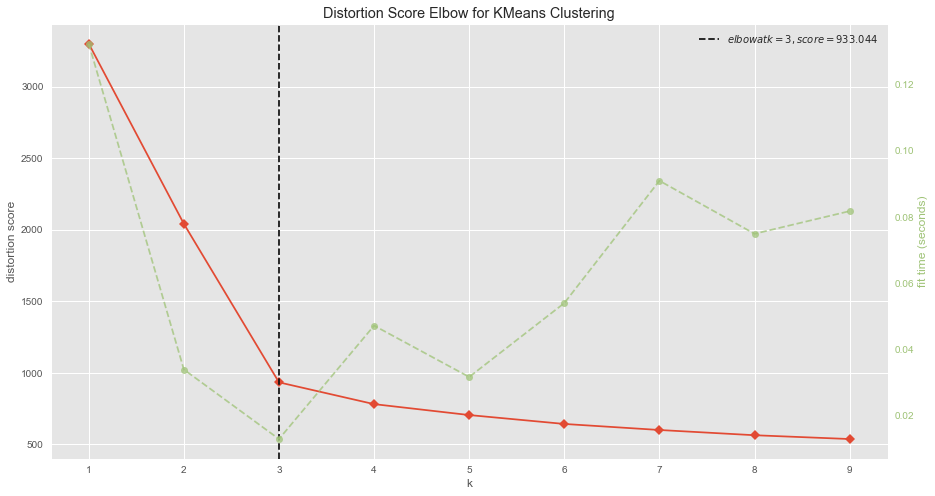

In [371]:
#Finding optimal number of clusters with elbow method
visualizer = KElbowVisualizer(KMeans(), k=(1,10), timings = True, locate_elbow = True)
visualizer.fit(df_z) 
visualizer.show();

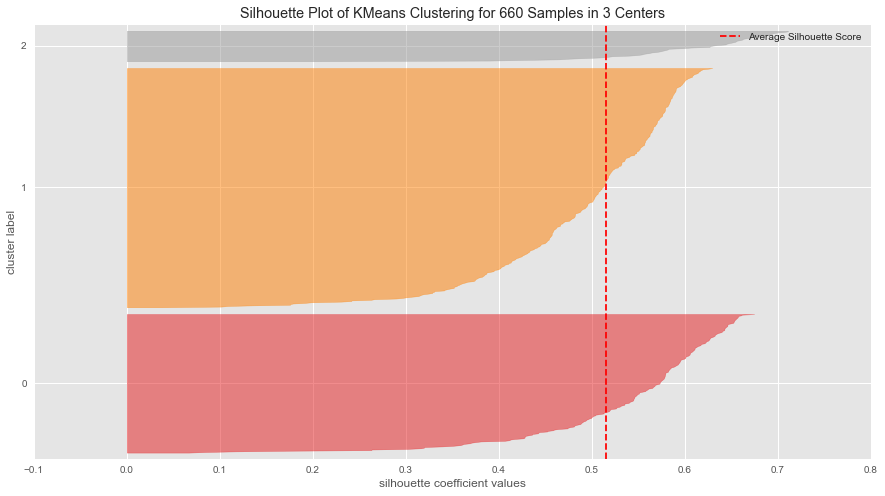

In [372]:
#Finding optimal number of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state = 1))
visualizer.fit(df_z)    
visualizer.show();

In [373]:
# Execute K-means clustering with value of 3
kmeans = KMeans(n_clusters=3, random_state = 1)
kmeans.fit(df_z);

In [374]:
# Calculate the average silhouette score
sil_score = silhouette_score(df_z, kmeans.labels_)
print('Average Silhouette Score: %.2f' % sil_score)

# record the score in a dataframe for later comparison
cluster_scores = {'Model': ['K-Means'], 
                'Clusters': 3, 
                'Sil_Score': sil_score
               }

# Store the accuracy results for each model in a dataframe for final comparison
resultsDf = pd.DataFrame(cluster_scores)
resultsDf = resultsDf[['Model', 'Clusters', 'Sil_Score']]
resultsDf

Average Silhouette Score: 0.52


,Model,Clusters,Sil_Score
0,K-Means,3,0.52


In [375]:
# Calculate the centroids for the columns to profile
centroids = kmeans.cluster_centers_

In [376]:
# Display centroids
centroid_df = pd.DataFrame(centroids, columns = list(df_z))
centroid_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,-0.60,-1.06,-0.90,0.32,1.15
1,-0.02,0.37,0.67,-0.55,-0.55
2,2.83,1.86,-1.11,2.83,-0.87


In [377]:
# Compute distance between cluster centers and each observation
kmeans.fit_transform(df_z.iloc[:,0:5])

array([[3.46561698, 2.92490849, 4.73966962],
       [2.60689704, 4.64141852, 4.55701125],
       [2.55795424, 1.98700152, 3.85505315],
       ...,
       [5.17607384, 4.47104901, 0.77990733],
       [7.1645827 , 6.59207788, 1.78110164],
       [6.14189402, 5.81635149, 0.93296828]])

In [378]:
# Add cluster group column of "K-Means" to our df_cluster dataframe
df_cluster['K-Means'] = kmeans.labels_
df_cluster['K-Means'] = df_cluster['K-Means'].astype('str')
df_cluster.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-Means
0,1.74,-1.25,-0.86,-0.55,-1.25,1
1,0.41,-0.79,-1.47,2.52,1.89,0
2,0.41,1.06,-0.86,0.13,0.15,1
3,-0.12,0.14,-0.86,-0.55,0.15,1
4,1.74,0.60,-1.47,3.20,-0.20,2


In [379]:
# Display numbers in each cluster
df_cluster['K-Means'].value_counts() 

1    386
0    224
2     50
Name: K-Means, dtype: int64

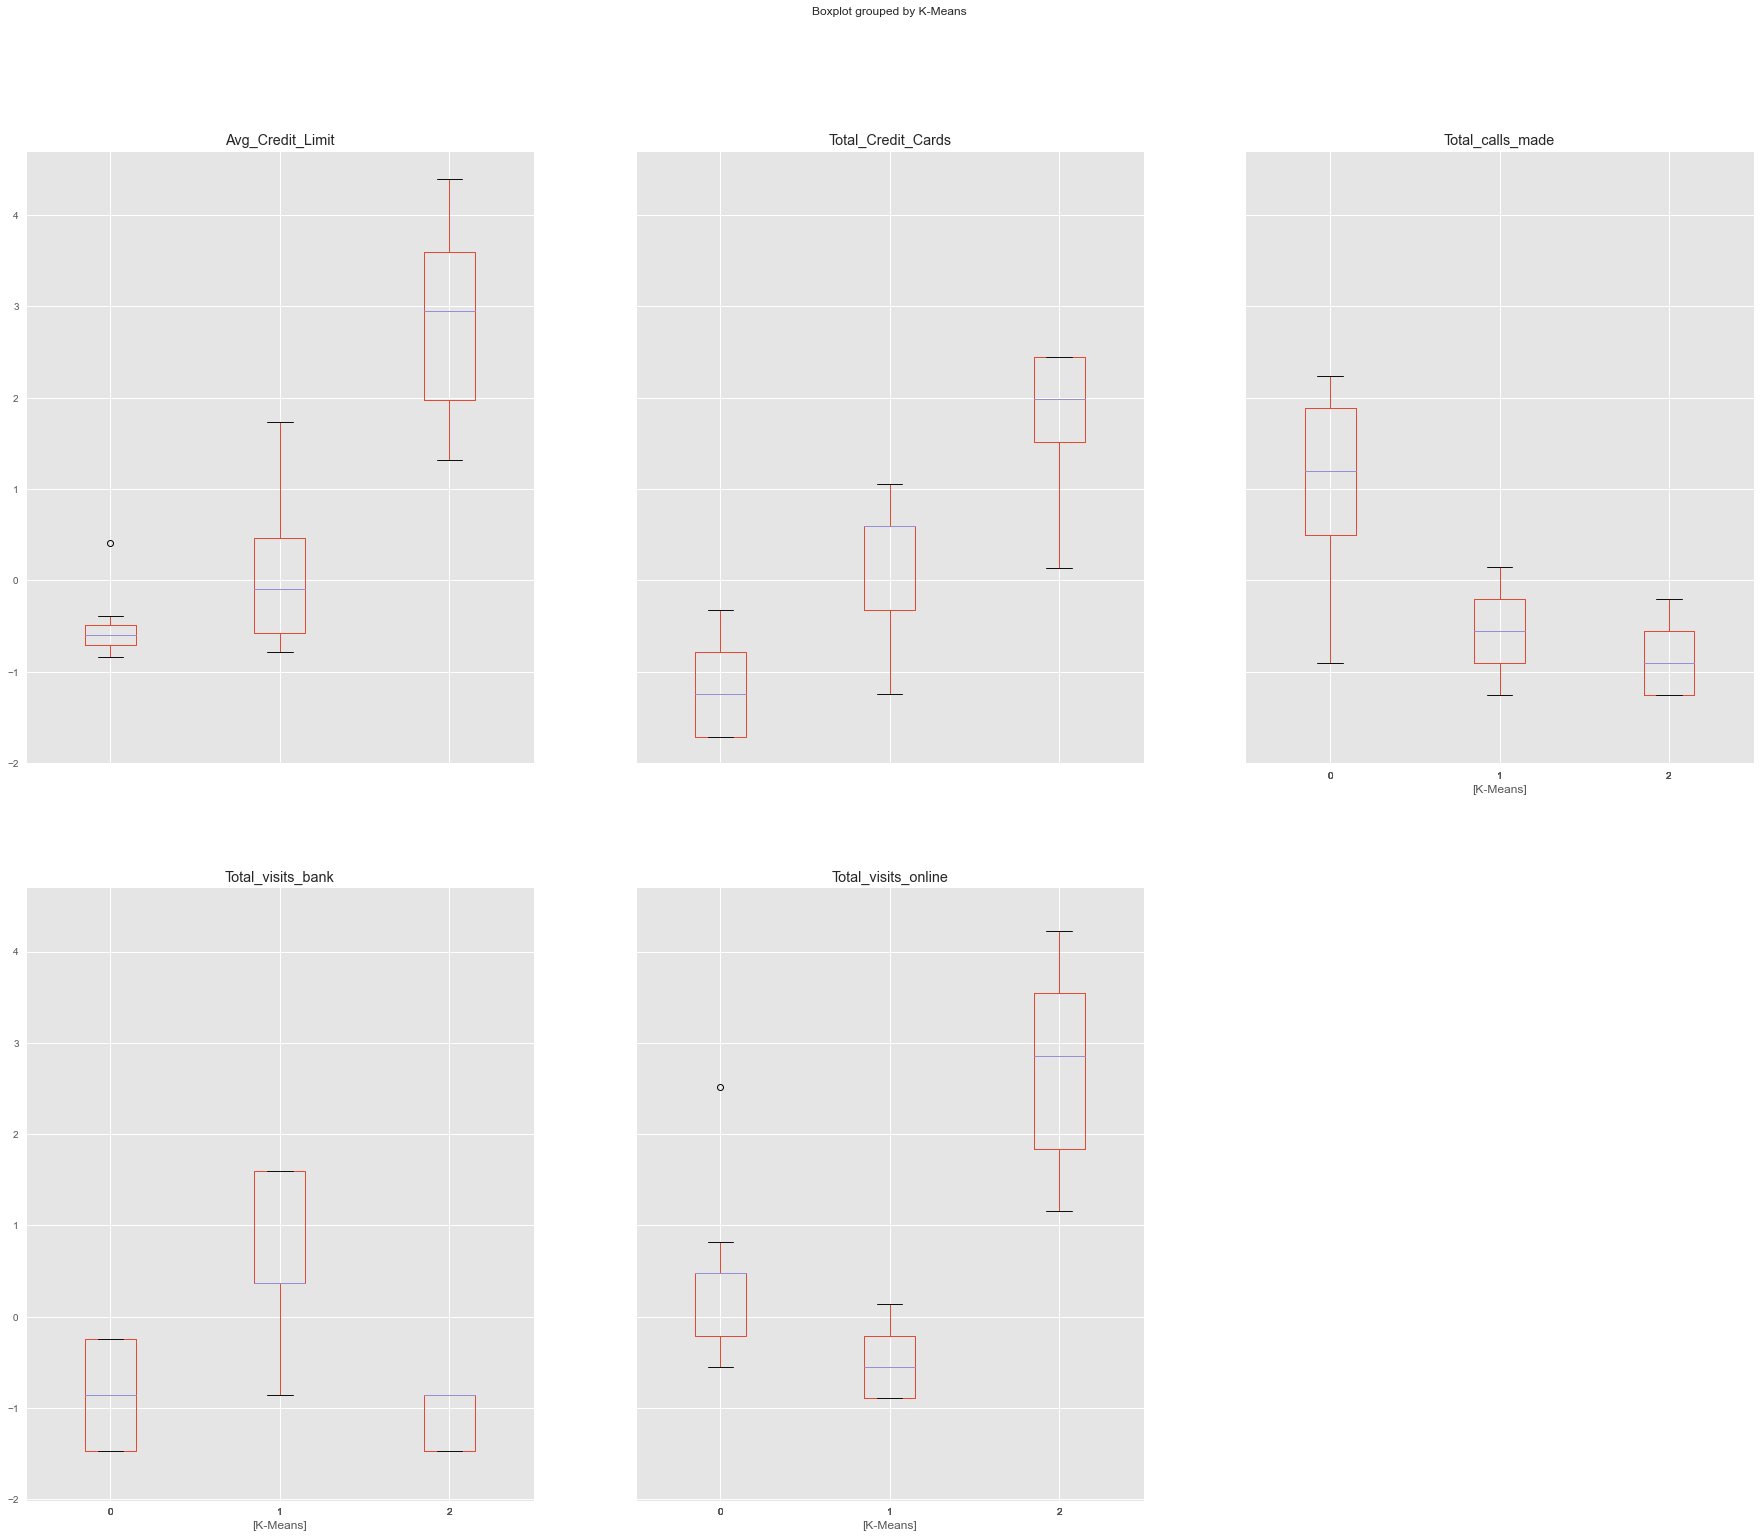

In [380]:
# Display boxplots of K-Means clustering
df_cluster.boxplot(by = 'K-Means',  layout=(2,3), figsize=(30, 25));

### Hierarchical Clustering

#### Linkage: Single (Minimum)

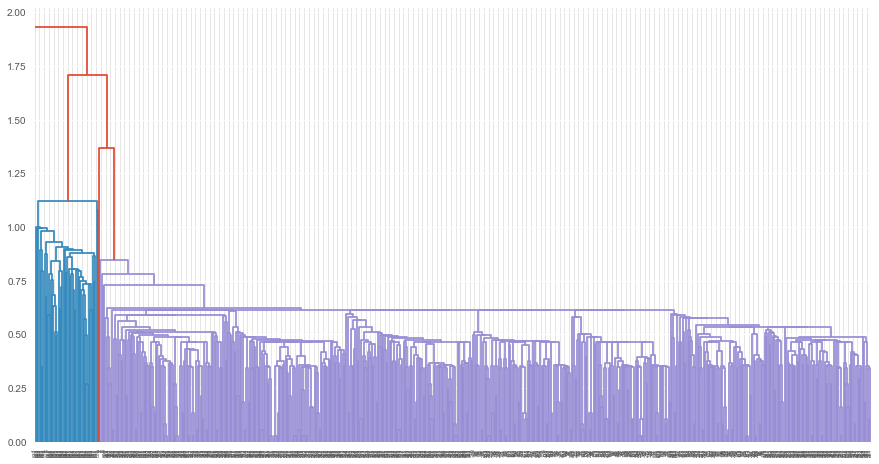

In [381]:
# Create a dendogram
Z = linkage(df_z, metric='euclidean', method='single')
dend = shc.dendrogram(Z)

In [382]:
# Cluster data using 2 and 3 clusters 
cluster_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'single')
cluster_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'single')

labels_2 = cluster_2.fit_predict(df_z)
labels_3 = cluster_3.fit_predict(df_z)

In [383]:
# Calculate cophenetic coefficient & silhouette scores
c, coph_dists = cophenet(Z, pdist(df_z))

sil_score_2 = silhouette_score(df_z, labels_2)
sil_score_3 = silhouette_score(df_z, labels_3)

print('Cophenetic Coefficient: %.2f' % c)
print()
print('Average Silhouette Score:')
print('2 clusters: %.2f' % sil_score_2)
print('3 clusters: %.2f' % sil_score_3)

Cophenetic Coefficient: 0.74

Average Silhouette Score:
2 clusters: 0.27
3 clusters: 0.37


In [384]:
# Record results
resultsDf.loc[1] = ['H_Single', 3, sil_score_3]
resultsDf

,Model,Clusters,Sil_Score
0,K-Means,3,0.52
1,H_Single,3,0.37


In [385]:
# Add the 3-cluster to our cluster dataset since it has a higher average silhouette score
df_cluster['H_Single'] = labels_3
df_cluster['H_Single'] = df_cluster['H_Single'].astype('str')

df_cluster.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-Means,H_Single
0,1.74,-1.25,-0.86,-0.55,-1.25,1,0
1,0.41,-0.79,-1.47,2.52,1.89,0,1
2,0.41,1.06,-0.86,0.13,0.15,1,0
3,-0.12,0.14,-0.86,-0.55,0.15,1,0
4,1.74,0.60,-1.47,3.20,-0.20,2,2


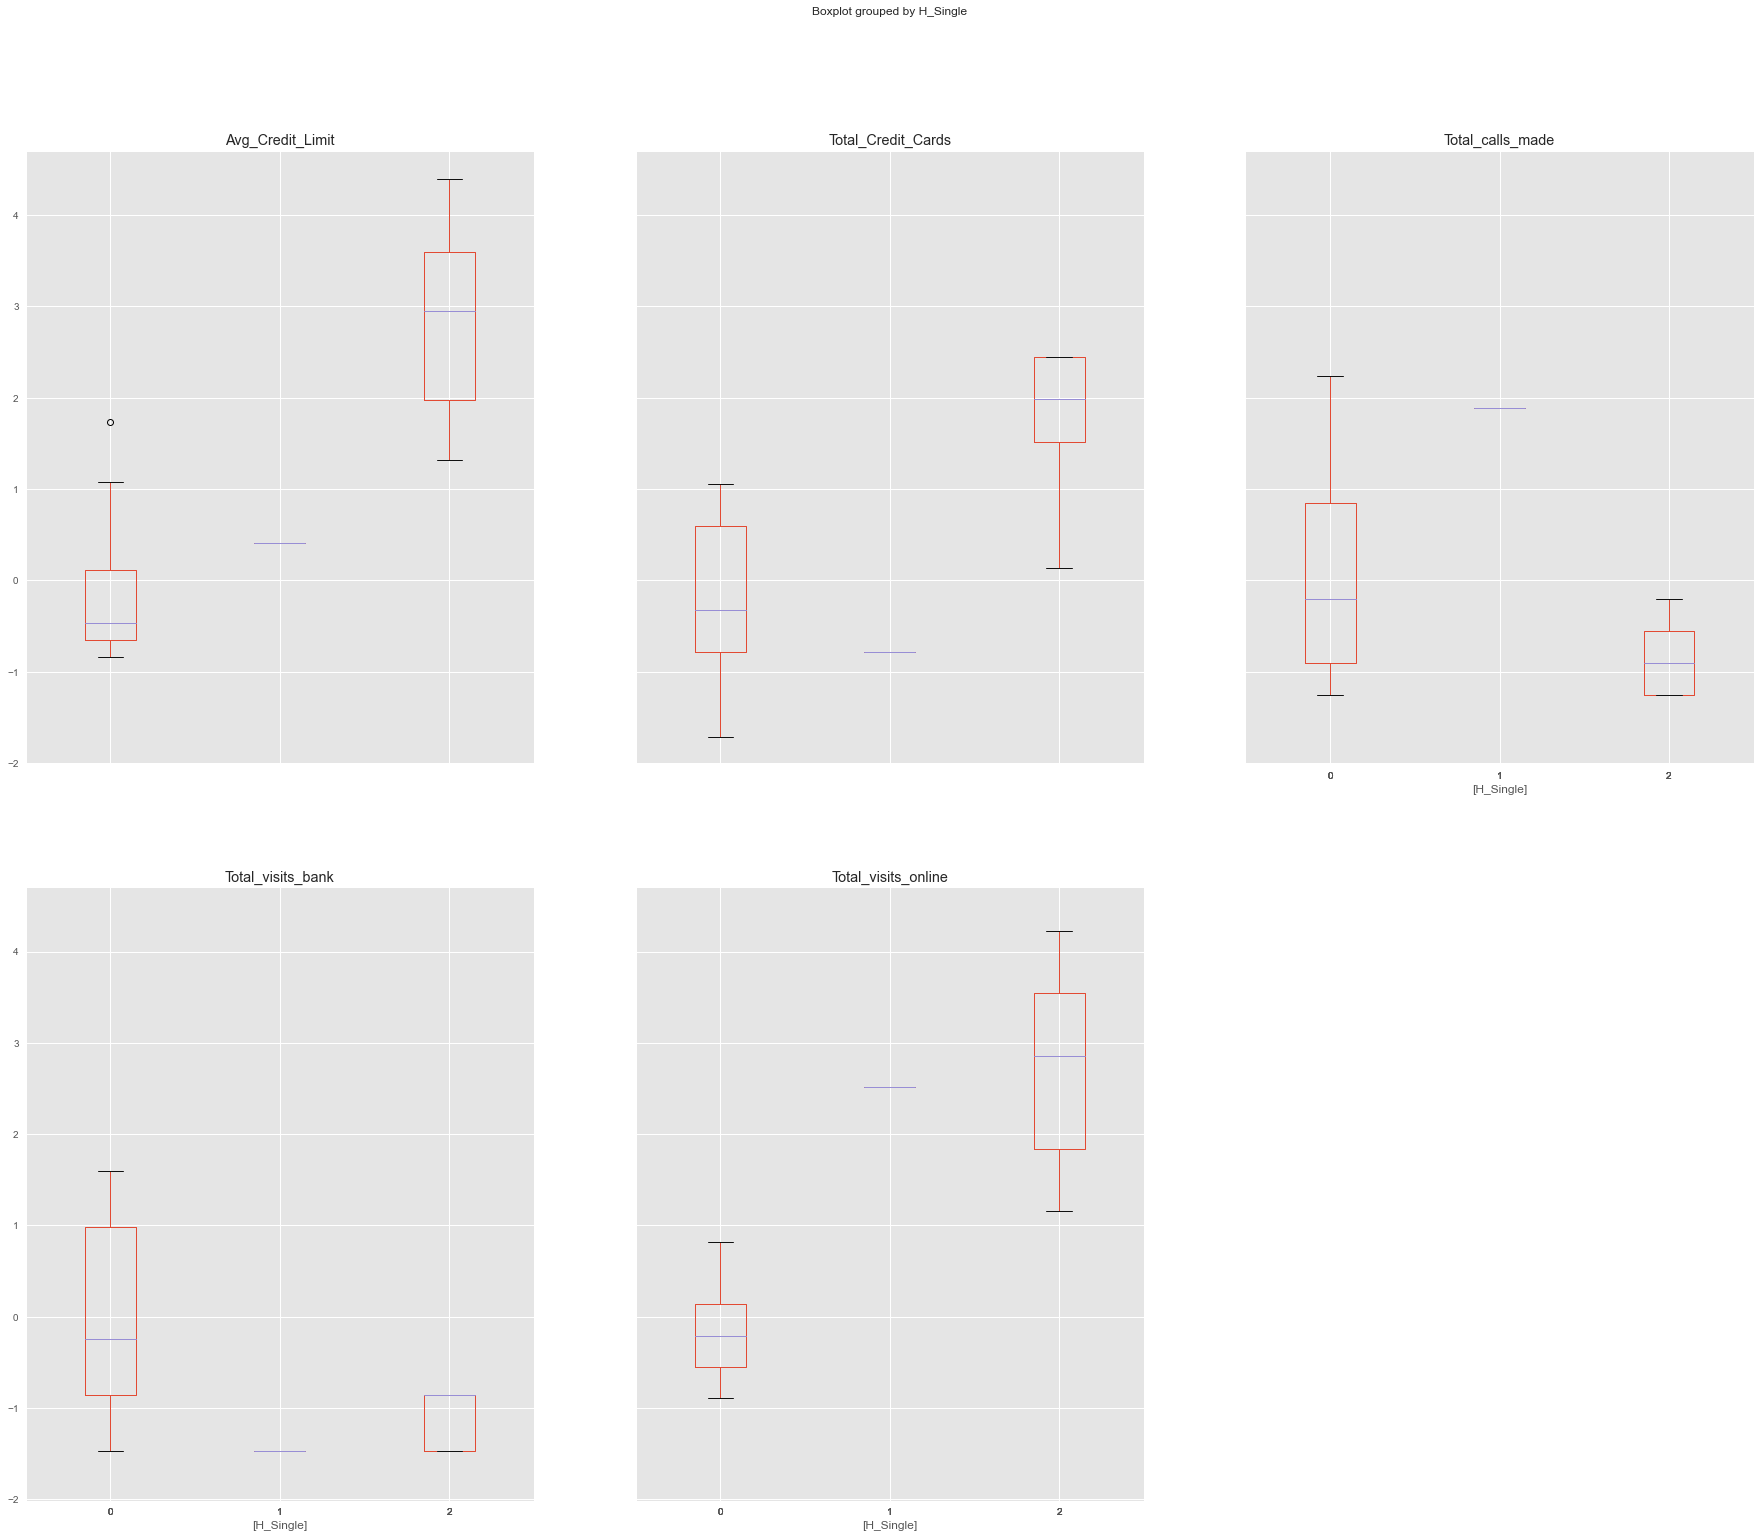

In [386]:
# Display boxplots of clustering
df_cluster.boxplot(by = 'H_Single',  layout=(2,3), figsize=(30, 25));

#### Linkage: Complete (Maximum)

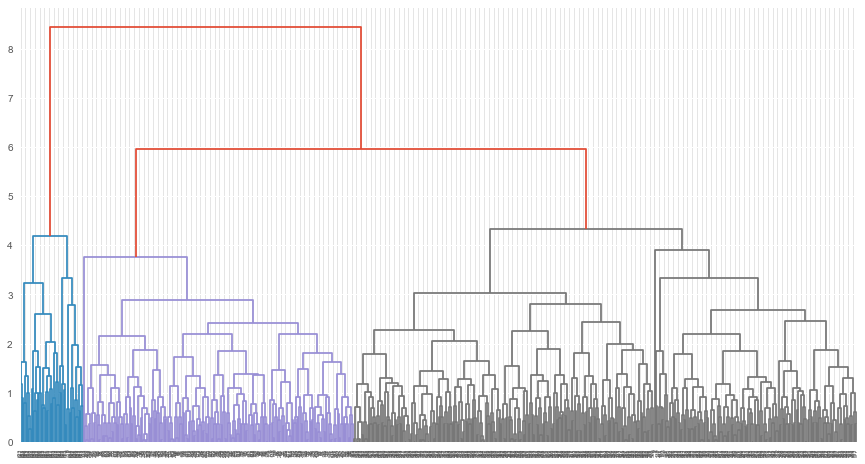

In [387]:
# Create a dendogram
Z = linkage(df_z, metric='euclidean', method='complete')
dend = shc.dendrogram(Z)

In [388]:
# Cluster data using 2 and 3 clusters 
cluster_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'complete')
cluster_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'complete')

labels_2 = cluster_2.fit_predict(df_z)
labels_3 = cluster_3.fit_predict(df_z)

In [389]:
# Calculate cophenetic coefficient & silhouette scores
c, coph_dists = cophenet(Z, pdist(df_z))

sil_score_2 = silhouette_score(df_z, labels_2)
sil_score_3 = silhouette_score(df_z, labels_3)

print('Cophenetic Coefficient: %.2f' % c)
print()
print('Average Silhouette Score:')
print('2 clusters: %.2f' % sil_score_2)
print('3 clusters: %.2f' % sil_score_3)

Cophenetic Coefficient: 0.86

Average Silhouette Score:
2 clusters: 0.57
3 clusters: 0.50


In [390]:
# Record results
resultsDf.loc[2] = ['H_Complete', 3, sil_score_3]
resultsDf

,Model,Clusters,Sil_Score
0,K-Means,3,0.52
1,H_Single,3,0.37
2,H_Complete,3,0.50


In [391]:
# Add the 3-cluster to our cluster dataset since dendogram seems to indicate 3 clusterings although silhouette is lower than 2 clusterings
df_cluster['H_Complete'] = labels_3
df_cluster['H_Complete'] = df_cluster['H_Complete'].astype('str')

df_cluster.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-Means,H_Single,H_Complete
0,1.74,-1.25,-0.86,-0.55,-1.25,1,0,0
1,0.41,-0.79,-1.47,2.52,1.89,0,1,2
2,0.41,1.06,-0.86,0.13,0.15,1,0,0
3,-0.12,0.14,-0.86,-0.55,0.15,1,0,0
4,1.74,0.60,-1.47,3.20,-0.20,2,2,1


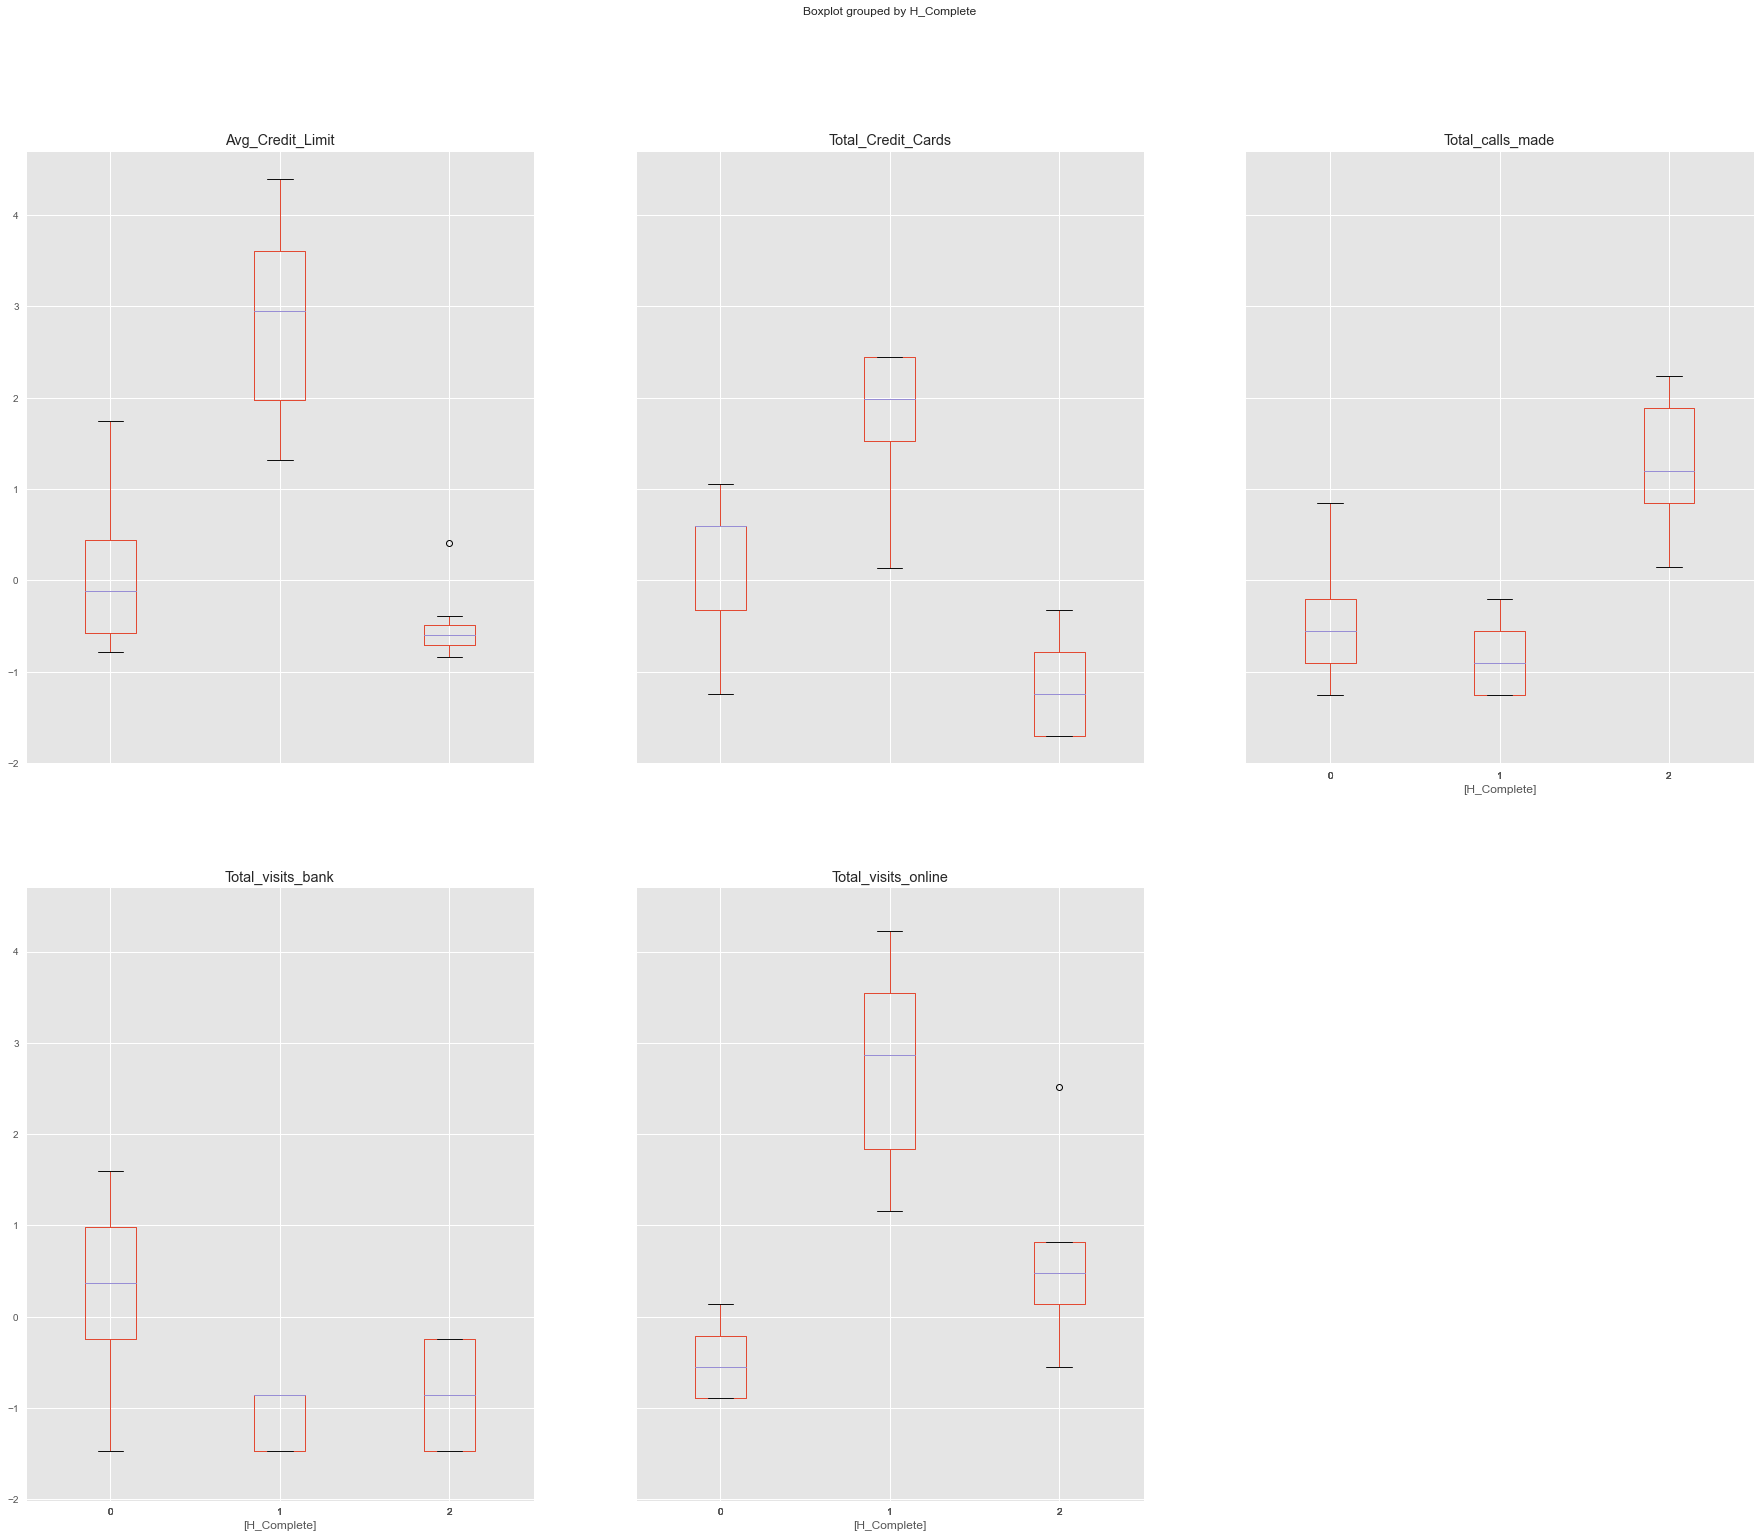

In [392]:
# Display boxplots of clustering
df_cluster.boxplot(by = 'H_Complete',  layout=(2,3), figsize=(30, 25));

#### Linkage Method: Mean (Average)

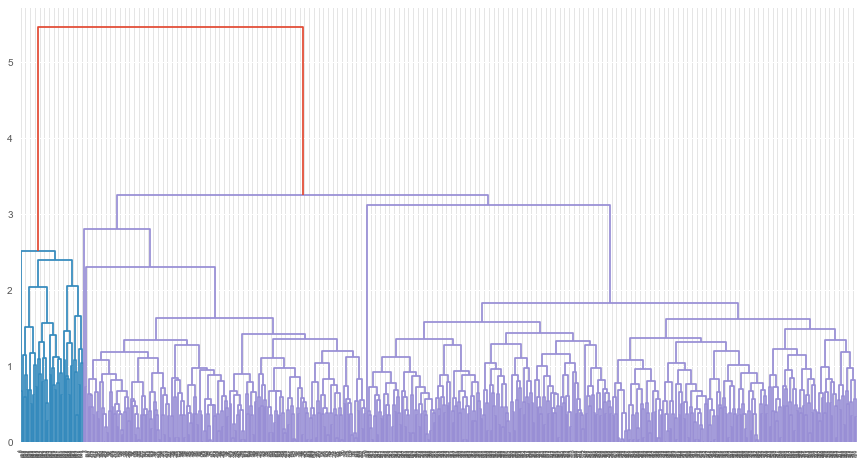

In [393]:
# Create a dendogram
Z = linkage(df_z, metric='euclidean', method='average')
dend = shc.dendrogram(Z)

In [394]:
# Cluster data using 2 and 3 clusters 
cluster_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'average')
cluster_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'average')

labels_2 = cluster_2.fit_predict(df_z)
labels_3 = cluster_3.fit_predict(df_z)

In [395]:
# Calculate cophenetic coefficient & silhouette scores
c, coph_dists = cophenet(Z, pdist(df_z))

sil_score_2 = silhouette_score(df_z, labels_2)
sil_score_3 = silhouette_score(df_z, labels_3)

print('Cophenetic Coefficient: %.2f' % c)
print()
print('Average Silhouette Score:')
print('2 clusters: %.2f' % sil_score_2)
print('3 clusters: %.2f' % sil_score_3)

Cophenetic Coefficient: 0.90

Average Silhouette Score:
2 clusters: 0.57
3 clusters: 0.52


In [396]:
# Record results
resultsDf.loc[3] = ['H_Mean', 3, sil_score_3]
resultsDf

,Model,Clusters,Sil_Score
0,K-Means,3,0.52
1,H_Single,3,0.37
2,H_Complete,3,0.50
3,H_Mean,3,0.52


In [397]:
# Add the 3-cluster to our cluster dataset 
df_cluster['H_Mean'] = labels_3
df_cluster['H_Mean'] = df_cluster['H_Mean'].astype('str')

df_cluster.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-Means,H_Single,H_Complete,H_Mean
0,1.74,-1.25,-0.86,-0.55,-1.25,1,0,0,0
1,0.41,-0.79,-1.47,2.52,1.89,0,1,2,2
2,0.41,1.06,-0.86,0.13,0.15,1,0,0,0
3,-0.12,0.14,-0.86,-0.55,0.15,1,0,0,0
4,1.74,0.60,-1.47,3.20,-0.20,2,2,1,1


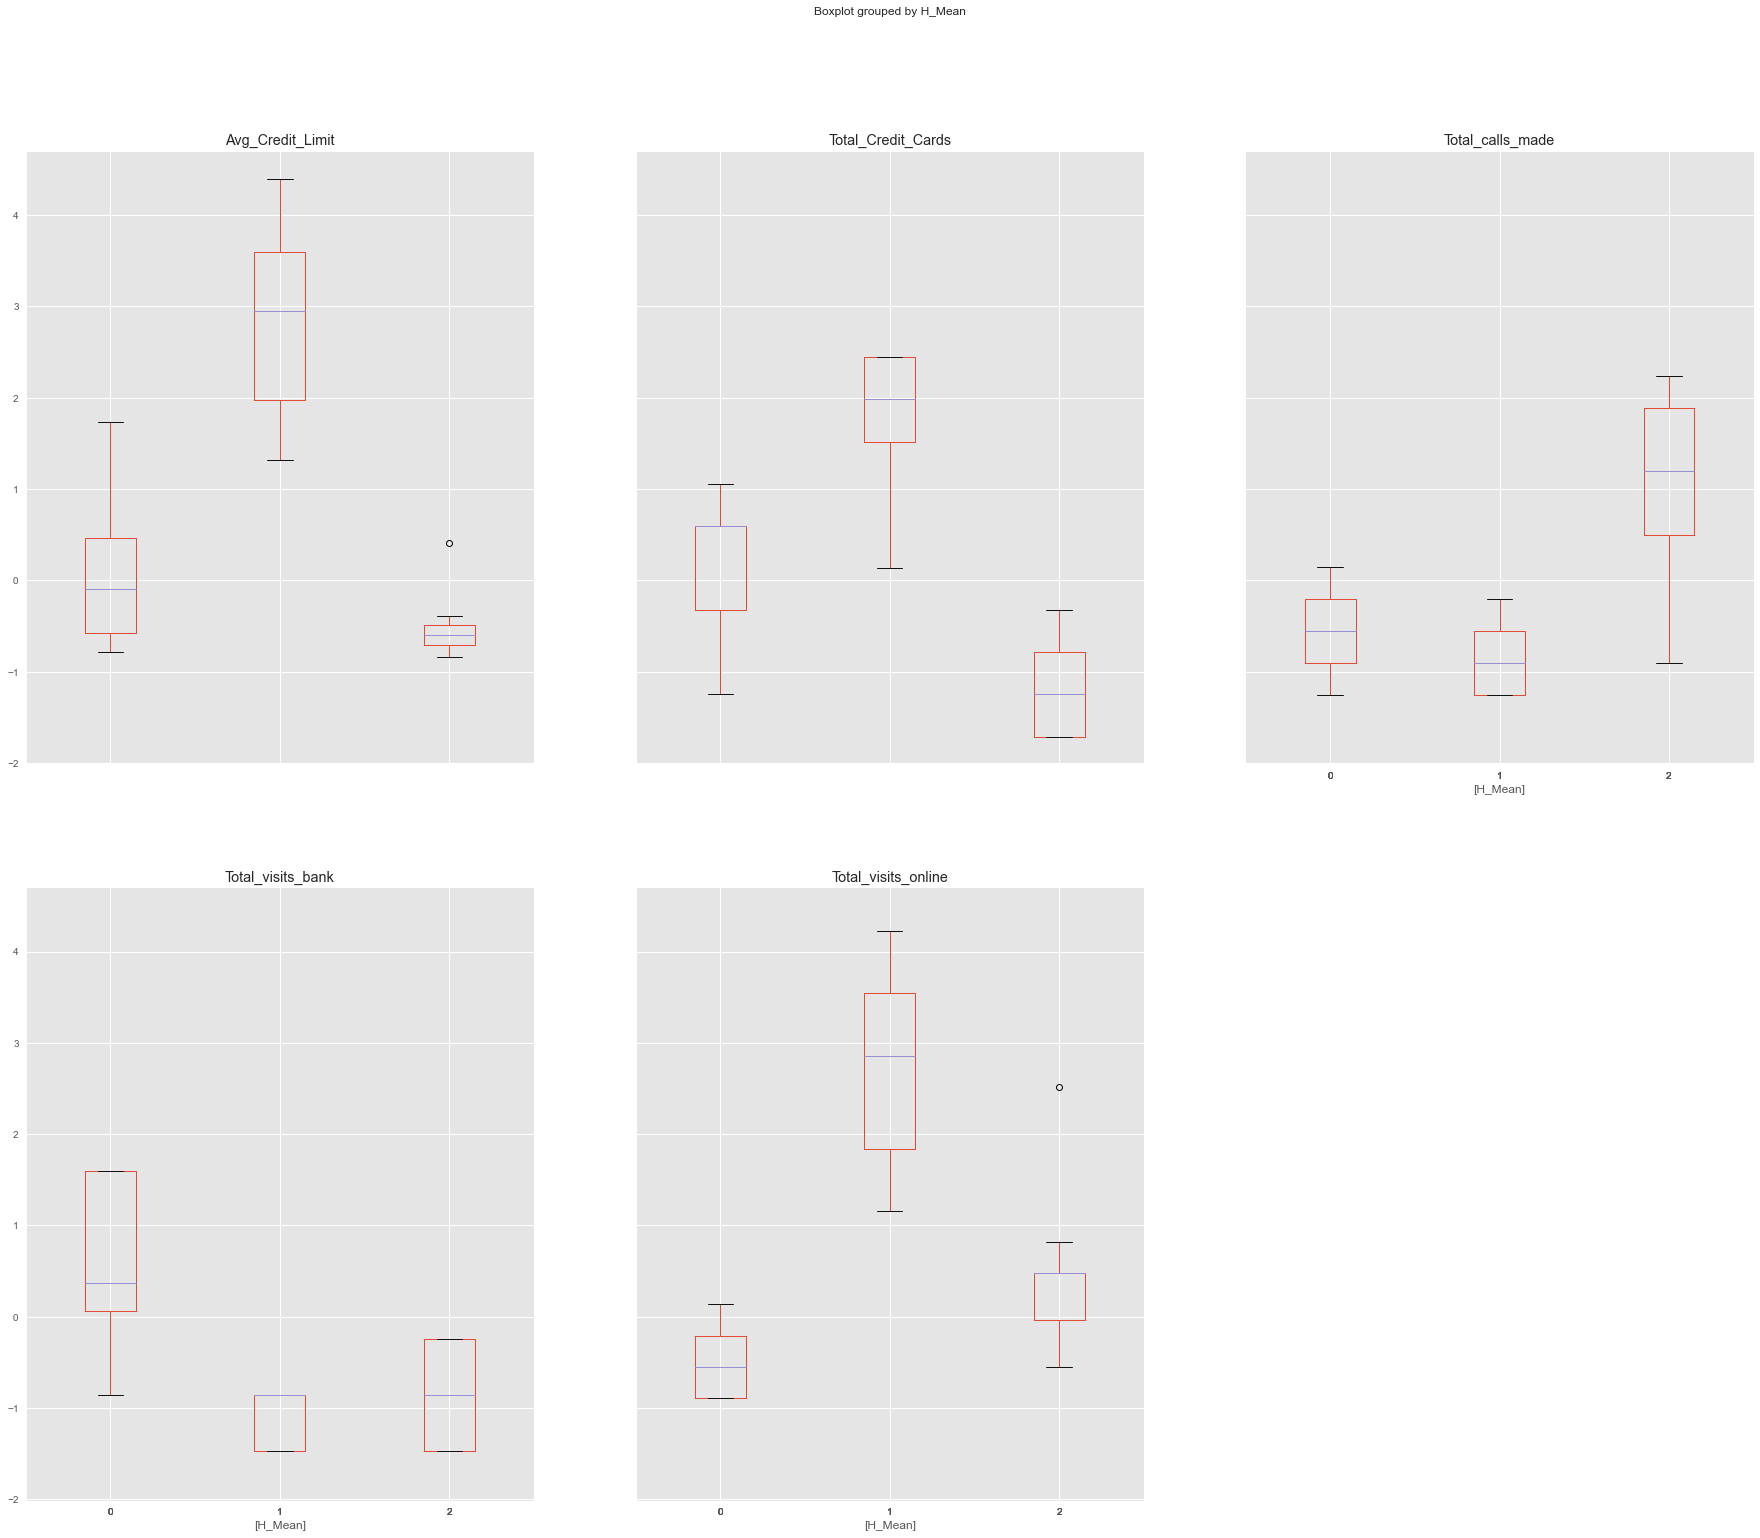

In [398]:
# Display boxplots of clustering
df_cluster.boxplot(by = 'H_Mean',  layout=(2,3), figsize=(30, 25));

#### Linkage Method: Ward (Minimum Variance)

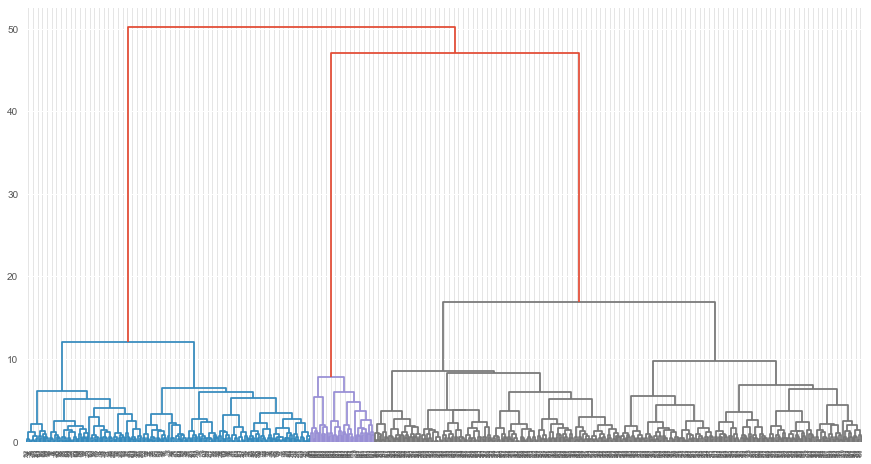

In [399]:
# Create a dendogram
Z = linkage(df_z, metric='euclidean', method='ward')
dend = shc.dendrogram(Z)

In [400]:
# Cluster data using 2 and 3 clusters 
cluster_2 = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
cluster_3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')

labels_2 = cluster_2.fit_predict(df_z)
labels_3 = cluster_3.fit_predict(df_z)

In [401]:
# Calculate cophenetic coefficient & silhouette scores
c, coph_dists = cophenet(Z, pdist(df_z))

sil_score_2 = silhouette_score(df_z, labels_2)
sil_score_3 = silhouette_score(df_z, labels_3)

print('Cophenetic Coefficient: %.2f' % c)
print()
print('Average Silhouette Score:')
print('2 clusters: %.2f' % sil_score_2)
print('3 clusters: %.2f' % sil_score_3)

Cophenetic Coefficient: 0.74

Average Silhouette Score:
2 clusters: 0.42
3 clusters: 0.51


In [402]:
# Record results
resultsDf.loc[4] = ['H_Ward', 3, sil_score_3]
resultsDf

,Model,Clusters,Sil_Score
0,K-Means,3,0.52
1,H_Single,3,0.37
2,H_Complete,3,0.50
3,H_Mean,3,0.52
4,H_Ward,3,0.51


In [403]:
# Add the 3-cluster to our cluster dataset since it has a higher average silhouette score
df_cluster['H_Ward'] = labels_3
df_cluster['H_Ward'] = df_cluster['H_Ward'].astype('str')

df_cluster.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K-Means,H_Single,H_Complete,H_Mean,H_Ward
0,1.74,-1.25,-0.86,-0.55,-1.25,1,0,0,0,0
1,0.41,-0.79,-1.47,2.52,1.89,0,1,2,2,1
2,0.41,1.06,-0.86,0.13,0.15,1,0,0,0,0
3,-0.12,0.14,-0.86,-0.55,0.15,1,0,0,0,0
4,1.74,0.60,-1.47,3.20,-0.20,2,2,1,1,2


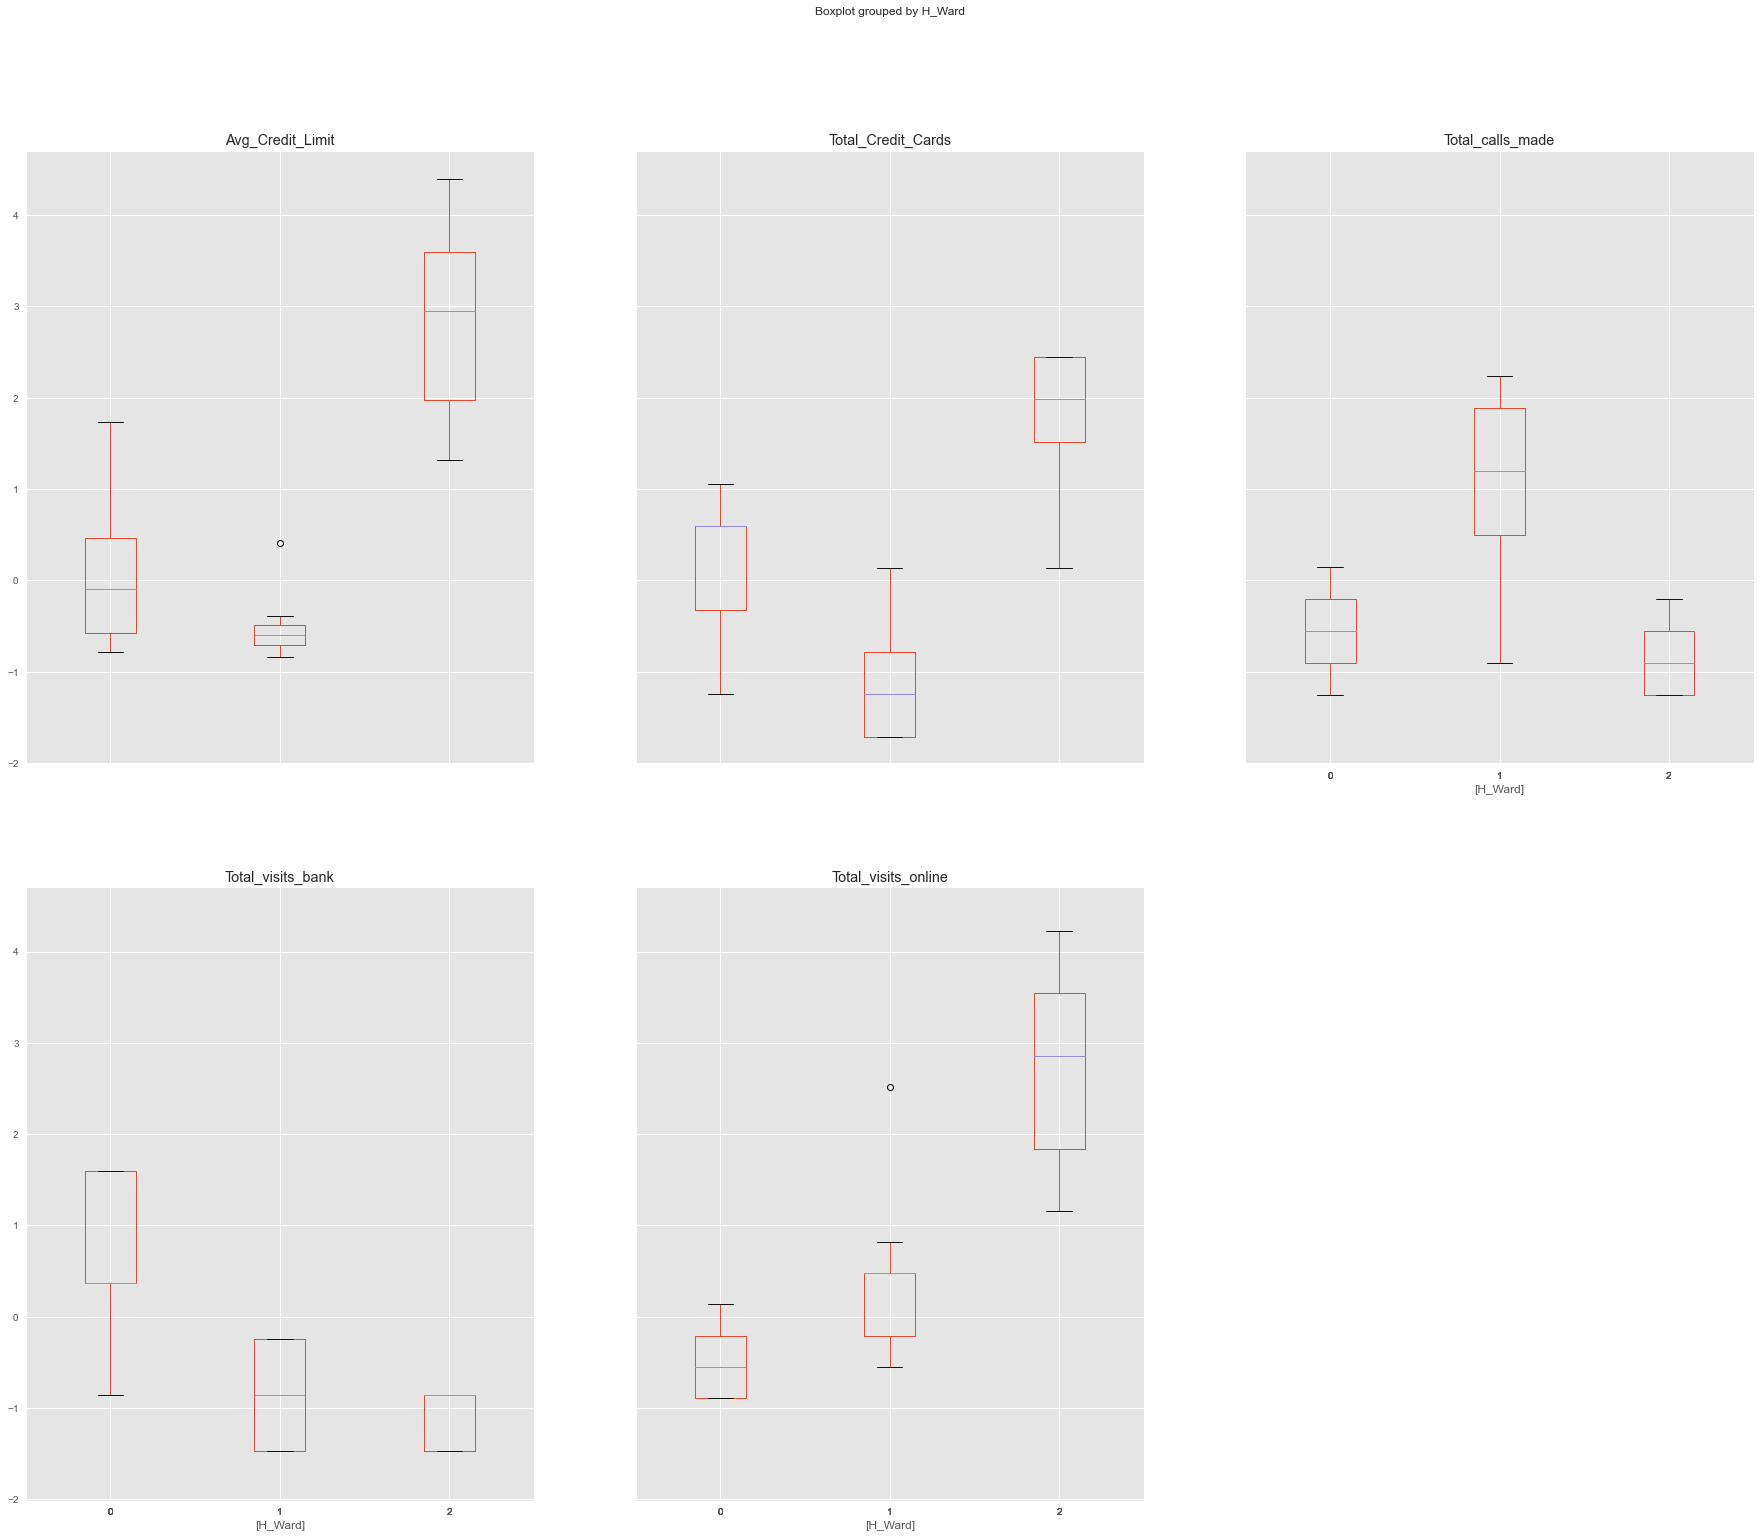

In [404]:
# Display boxplots of clustering
df_cluster.boxplot(by = 'H_Ward',  layout=(2,3), figsize=(30, 25));

## Results

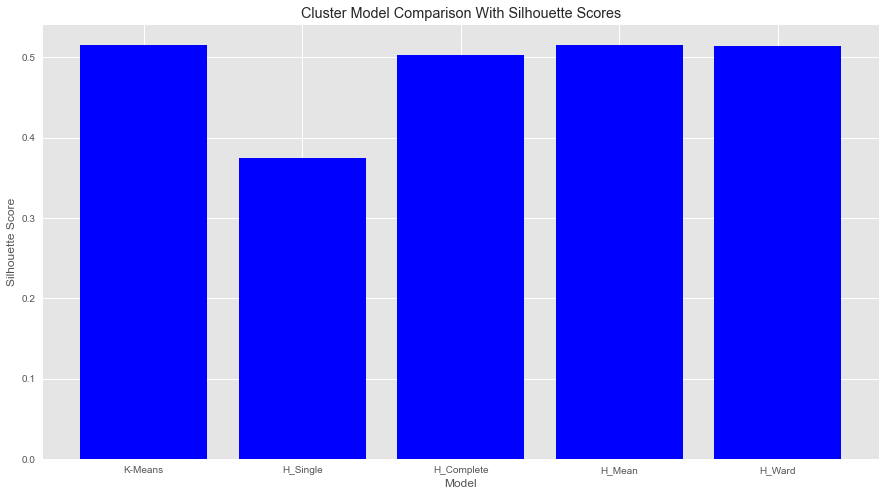

In [405]:
# Display Model Scores via Bar Chart
plt.bar("Model", "Sil_Score", data = resultsDf, color = "blue")
plt.xlabel("Model")
plt.ylabel("Silhouette Score")
plt.title("Cluster Model Comparison With Silhouette Scores")
plt.show()

In [406]:
# Display Model Scores Numerically
resultsDf

,Model,Clusters,Sil_Score
0,K-Means,3,0.52
1,H_Single,3,0.37
2,H_Complete,3,0.50
3,H_Mean,3,0.52
4,H_Ward,3,0.51


#### Observations:
- Some models gave a little higher silhouette score for two clusters than with 3 clusters.
- We kept 3 clusters for better resolution for segmentation of the customers.
- K-Means and Hiearchical 'Mean' Clustering appear to give the highest Silhouette Scores with similar clusterings 

#### Analysis of Clusters

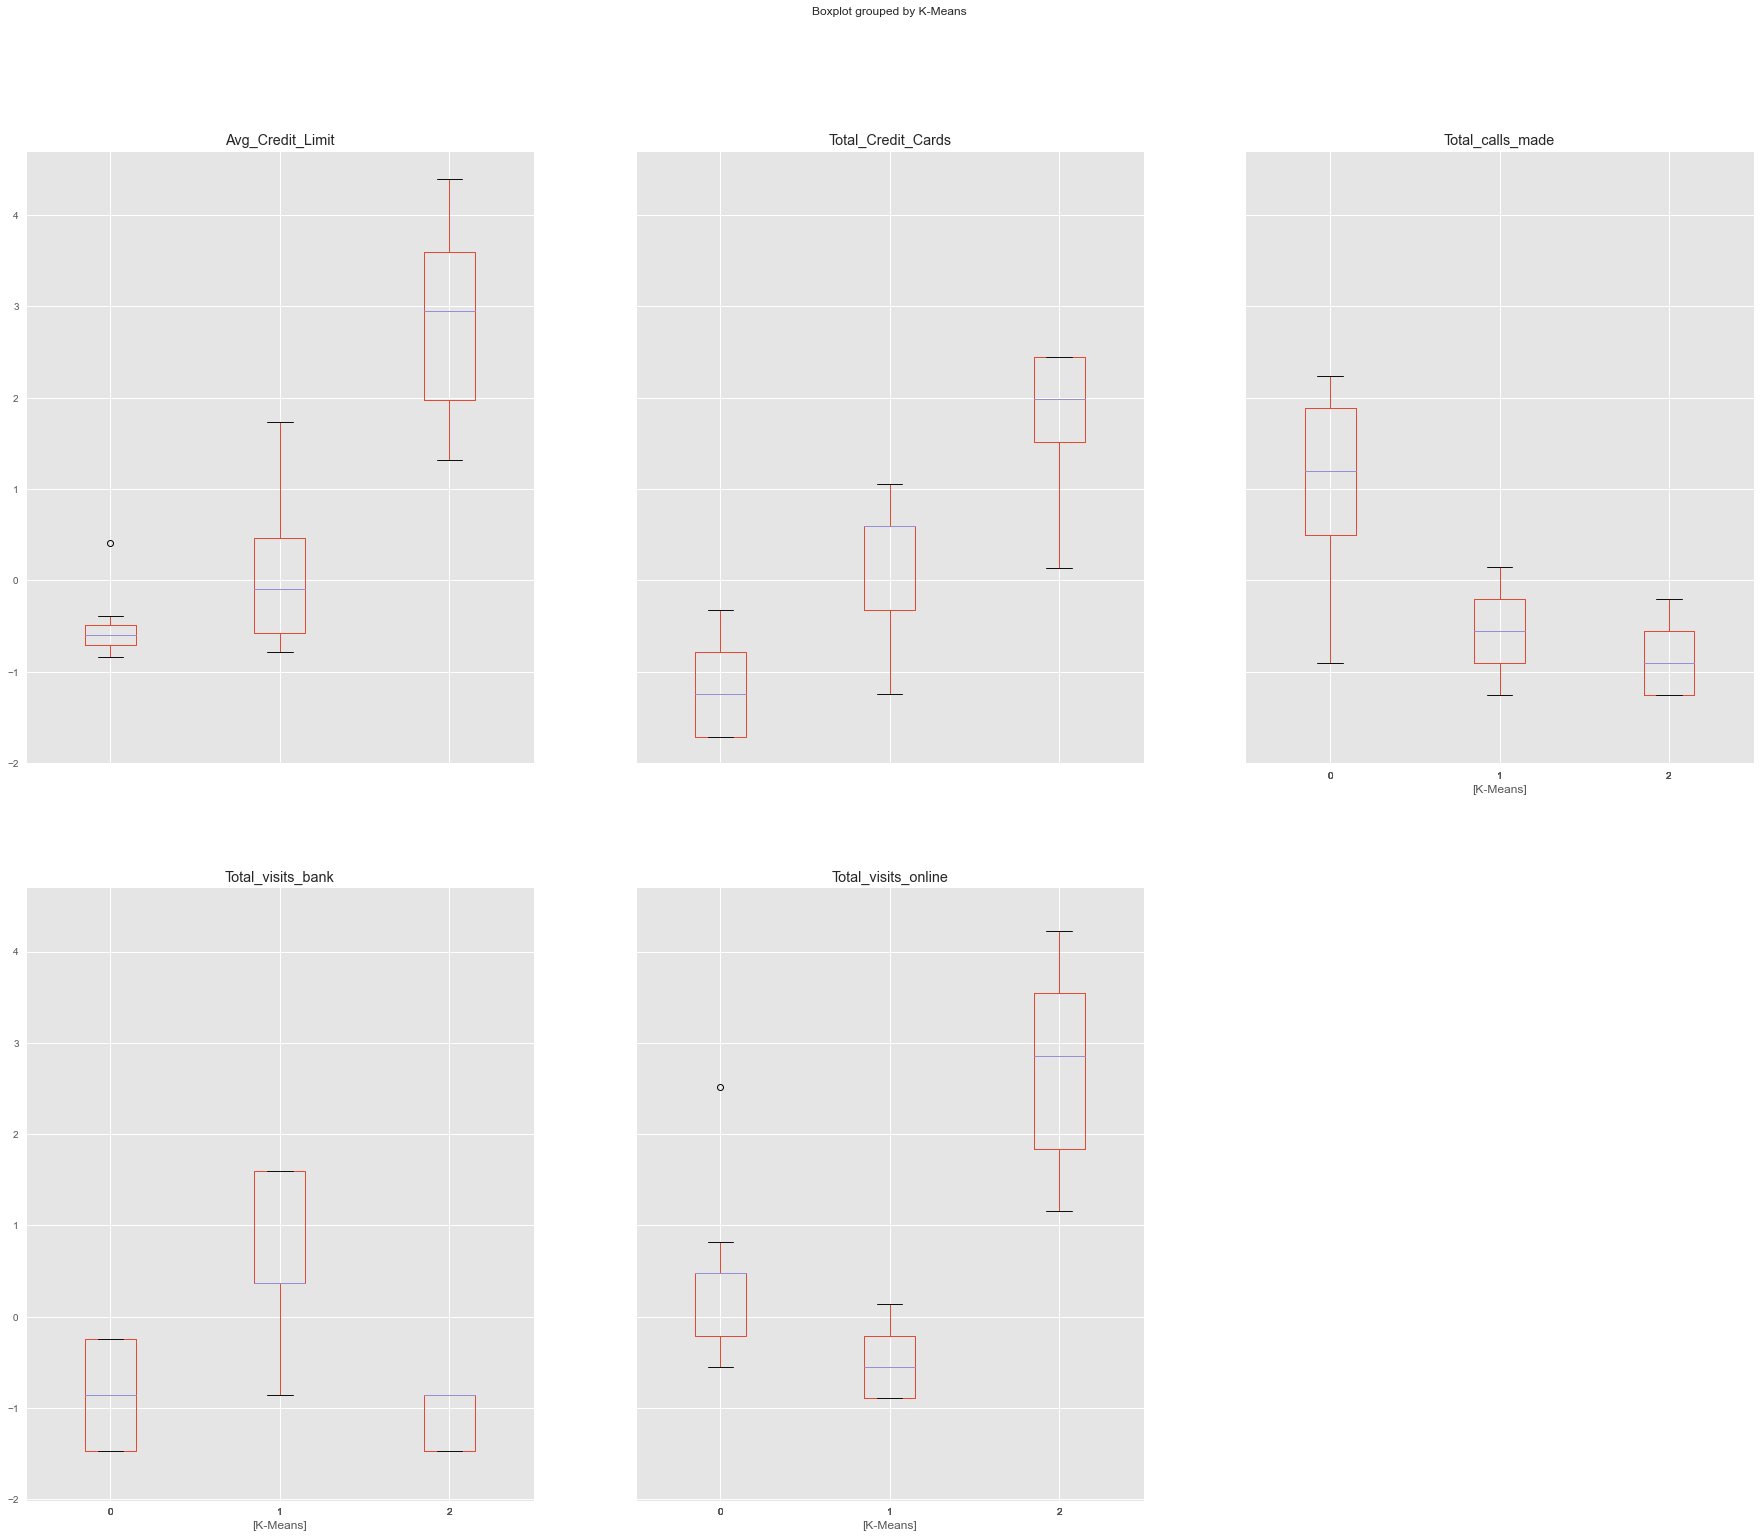

In [407]:
# Display boxplots of K-Means clustering again for visualization 
df_cluster.boxplot(by = 'K-Means',  layout=(2,3), figsize=(30, 25));

There appears to be 3 customer segments:
- Segment 0: low credit limits, low number of credit cards, presumably lower income
- Segment 1: middle credit limits, middle number of credit cards, presumeably middle income
- Segment 2: high credit limits, high number of credit cards, presumeably high income

Marketing Recommendations for Service Delivery and Customer Service Efficiency:
- Segment 0: tends to do more banking service by calling on the phone
- Segment 1: tends to do more banking service by in-person visits to the bank
- Segment 2: tends to do more banking service by online services